Source - https://huggingface.co/mychen76/mistral7b_ocr_to_json_v1

Tutorial - https://www.datacamp.com/tutorial/mistral-7b-tutorial

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True,
)

# control model memory allocation between devices for low GPU resource (0,cpu)
device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": 0,
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": 0,
    "model.layers":0,
    "model.norm":0    
}
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

modelname='mychen76/mistral7b_ocr_to_json_v1'

tokenizer = AutoTokenizer.from_pretrained(modelname, use_fast=True, use_cache=True)
model = AutoModelForCausalLM.from_pretrained(modelname, quantization_config=bnb_config, torch_dtype=torch.bfloat16, device_map=device_map,trust_remote_code=True)

cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from paddleocr import PaddleOCR, draw_ocr
from ast import literal_eval
import json

paddleocr = PaddleOCR(lang="en",ocr_version="PP-OCRv4",show_log = False,use_gpu=False)

from PIL import Image
imageName='image1.jpg'
image=Image.open(imageName)

def paddle_scan(paddleocr,img_path_or_nparray):
    result = paddleocr.ocr(img_path_or_nparray,cls=True)
    result = result[0]
    boxes = [line[0] for line in result]       #boundign box 
    txts = [line[1][0] for line in result]     #raw text
    scores = [line[1][1] for line in result]   # scores
    return  txts, result

#image

In [3]:
%%time
# perform ocr scan
receipt_texts, receipt_boxes = paddle_scan(paddleocr,imageName)
#print(50*"--","\ntext only:\n",receipt_texts)
#print(50*"--","\nocr boxes:\n",receipt_boxes)

[2024/07/10 12:37:03] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
CPU times: total: 9.59 s
Wall time: 1.77 s


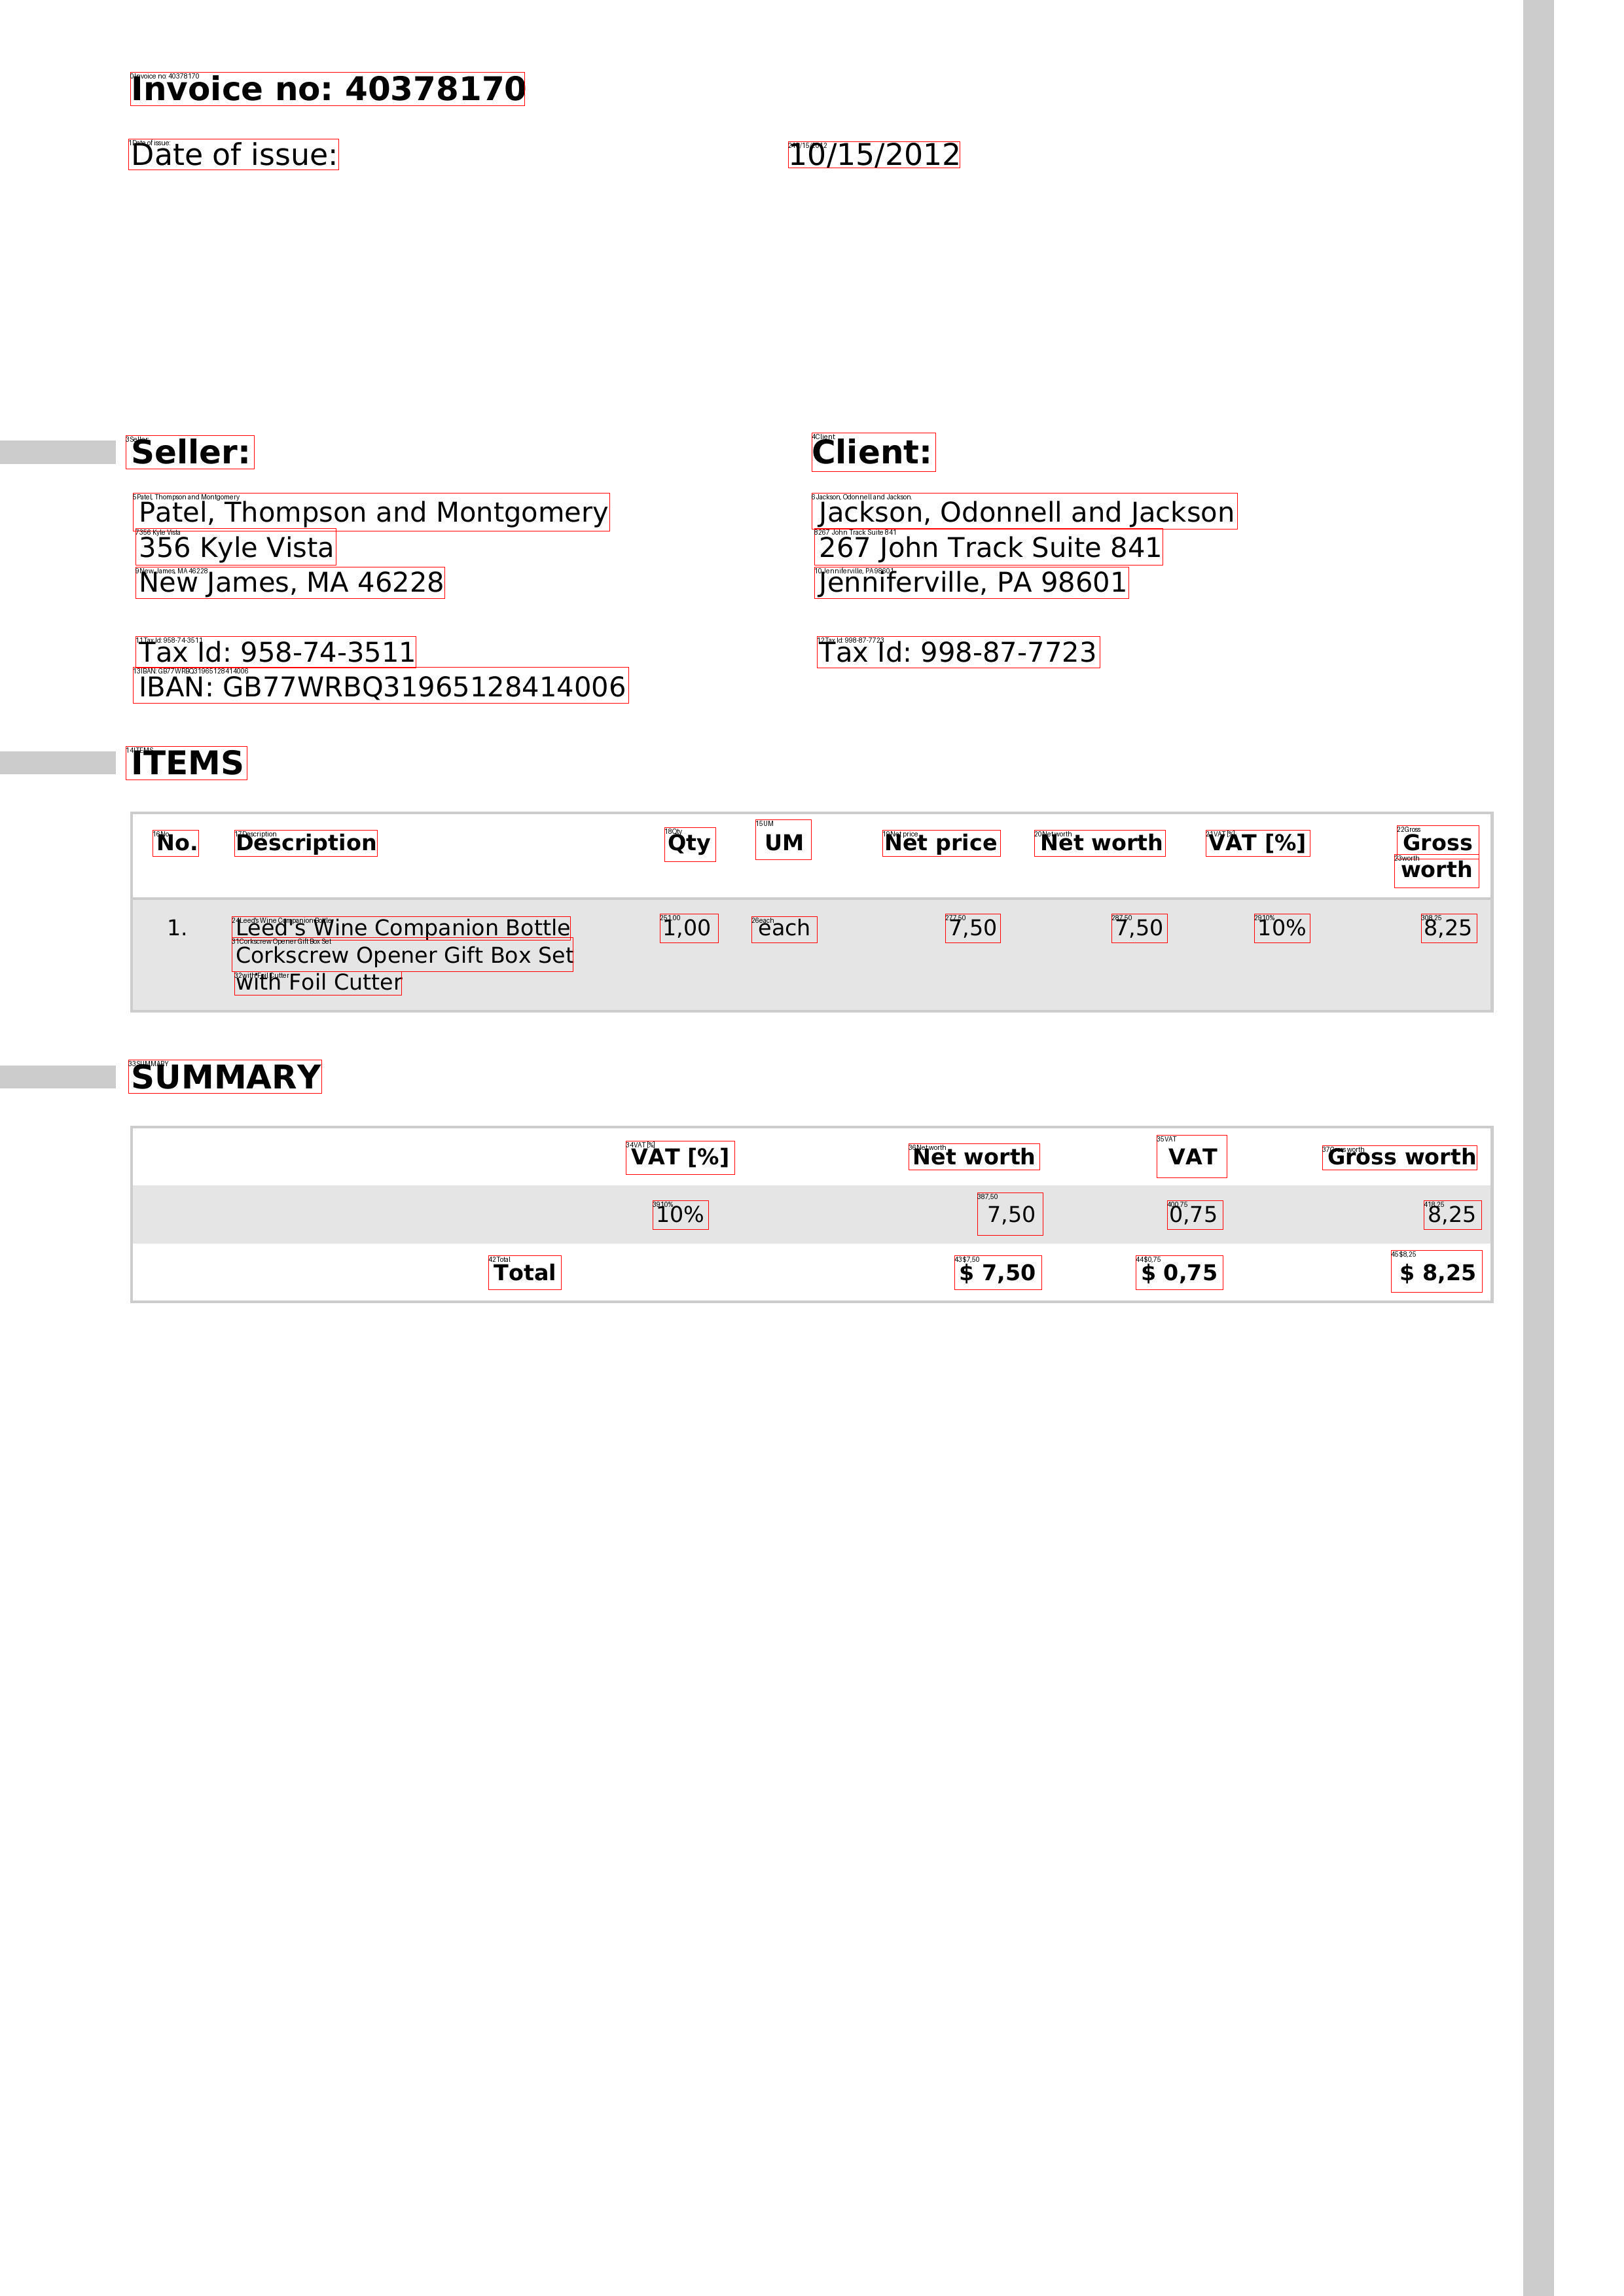

In [4]:
from PIL import ImageDraw
import numpy as np
image2 = image
draw = ImageDraw.Draw(image2)
for i, box in enumerate(receipt_boxes):
    text = box[1][0]
    box = np.array(box[0]).astype(np.int32)
    xmin = min(box[:, 0])
    ymin = min(box[:, 1])
    xmax = max(box[:, 0])
    ymax = max(box[:, 1])
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{i}{text}", fill="black")
image2

In [5]:
prompt=f"""### Instruction:
You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into structure receipt data object. 
Don't make up value not in the Input. Output the JSON only```json

### Input:
{receipt_boxes}

### Output:
"""
prompt

'### Instruction:\nYou are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into structure receipt data object. \nDon\'t make up value not in the Input. Output the JSON only```json\n\n### Input:\n[[[[199.0, 110.0], [801.0, 110.0], [801.0, 161.0], [199.0, 161.0]], (\'Invoice no: 40378170\', 0.998958945274353)], [[[196.0, 212.0], [517.0, 212.0], [517.0, 259.0], [196.0, 259.0]], (\'Date of issue:\', 0.9980012774467468)], [[[1204.0, 216.0], [1466.0, 216.0], [1466.0, 256.0], [1204.0, 256.0]], (\'10/15/2012\', 0.9996285438537598)], [[[192.0, 665.0], [388.0, 665.0], [388.0, 716.0], [192.0, 716.0]], (\'Seller:\', 0.9992272257804871)], [[[1240.0, 661.0], [1429.0, 661.0], [1429.0, 720.0], [1240.0, 720.0]], (\'Client:\', 0.9989991188049316)], [[[203.0, 753.0], [931.0, 760.0], [930.0, 811.0], [203.0, 804.0]], (\'Patel, Thompson and Montgomery\', 0.9912818074226379)], [[[1240.0, 756.0], [1890.0, 753.0], [1890.0, 804.0], [1241.0, 808.0]], (\'Jackson, O

In [6]:
%%time

with torch.inference_mode():
    inputs = tokenizer(prompt,return_tensors="pt",truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=100) 
    result_text = tokenizer.batch_decode(outputs)[0]
    print(result_text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> ### Instruction:
You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into structure receipt data object. 
Don't make up value not in the Input. Output the JSON only```json

### Input:
[[[[199.0, 110.0], [801.0, 110.0], [801.0, 161.0], [199.0, 161.0]], ('Invoice no: 40378170', 0.998958945274353)], [[[196.0, 212.0], [517.0, 212.0], [517.0, 259.0], [196.0, 259.0]], ('Date of issue:', 0.9980012774467468)], [[[1204.0, 216.0], [1466.0, 216.0], [1466.0, 256.0], [1204.0, 256.0]], ('10/15/2012', 0.9996285438537598)], [[[192.0, 665.0], [388.0, 665.0], [388.0, 716.0], [192.0, 716.0]], ('Seller:', 0.9992272257804871)], [[[1240.0, 661.0], [1429.0, 661.0], [1429.0, 720.0], [1240.0, 720.0]], ('Client:', 0.9989991188049316)], [[[203.0, 753.0], [931.0, 760.0], [930.0, 811.0], [203.0, 804.0]], ('Patel, Thompson and Montgomery', 0.9912818074226379)], [[[1240.0, 756.0], [1890.0, 753.0], [1890.0, 804.0], [1241.0, 808.0]], ('Jackson, Odonnell and Jack